In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
plt.rcParams['font.size'] = '16'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Fixing random seeds and workers for reproducibility purposes. 

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0);

### Loading the dataset.

In [4]:
df = pd.read_csv('Data_for_UCI_named.csv')
df = df.drop(columns=['p1', 'stab'])
df['stabf'] = df['stabf'].map({'unstable': 0, 'stable': 1})
df.head()

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0


In [5]:
X = df.drop(columns=['stabf']).to_numpy()
y = df['stabf'].to_numpy()
print(f'{X.shape=}, {y.shape=}')

X.shape=(10000, 11), y.shape=(10000,)


### Baseline model in scikit-learn

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f'{X_train.shape=}, {y_train.shape=}')
print(f'{X_test.shape=}, {y_test.shape=}')

X_train.shape=(8000, 11), y_train.shape=(8000,)
X_test.shape=(2000, 11), y_test.shape=(2000,)


In [7]:
params = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
model = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=0)

gscv = GridSearchCV(model, params)
gscv.fit(X_train, y_train)
gscv.best_params_

{'activation': 'logistic'}

In [8]:
model = MLPClassifier(hidden_layer_sizes=(5,), activation='logistic', max_iter=1000, random_state=0)
model.fit(X_train, y_train)

print('Train set accuracy:', model.score(X_train, y_train))
print('Test set accuracy:', model.score(X_test, y_test))

Train set accuracy: 0.910625
Test set accuracy: 0.91


In [9]:
epochs = model.n_iter_
epochs

780

### PyTorch classes for models and datasets.

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.hidden = nn.Linear(11, 5)
        self.output = nn.Linear(5, 1)
        
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        return self.output(x)
    

class MLP_different(nn.Module):
    def __init__(self):
        super(MLP_different, self).__init__()
        
        self.fc_identity = nn.Linear(11, 1)
        self.fc_sigmoid = nn.Linear(11, 1)
        self.fc_relu = nn.Linear(11, 1)
        self.fc_leaky_relu = nn.Linear(11, 1)
        self.fc_tanh = nn.Linear(11, 1)
        
        self.output = nn.Linear(5, 1)
        
    
    def forward(self, x):
        x = torch.cat((
            self.fc_identity(x),
            torch.sigmoid(self.fc_sigmoid(x)),
            F.relu(self.fc_relu(x)),
            F.leaky_relu(self.fc_leaky_relu(x)),
            torch.tanh(self.fc_tanh(x))
        ), dim=1)
        
        return self.output(x)
    
    
class MLP_different_bn(nn.Module):
    def __init__(self):
        super(MLP_different_bn, self).__init__()
        
        self.fc_identity = nn.Linear(11, 1)
        self.fc_sigmoid = nn.Linear(11, 1)
        self.fc_relu = nn.Linear(11, 1)
        self.fc_leaky_relu = nn.Linear(11, 1)
        self.fc_tanh = nn.Linear(11, 1)
        
        self.bn = nn.BatchNorm1d(5)
        self.output = nn.Linear(5, 1)
        
    
    def forward(self, x):
        x = torch.cat((
            self.fc_identity(x),
            torch.sigmoid(self.fc_sigmoid(x)),
            F.relu(self.fc_relu(x)),
            F.leaky_relu(self.fc_leaky_relu(x)),
            torch.tanh(self.fc_tanh(x))
        ), dim=1)
        
        return self.output(self.bn(x))

In [11]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return X[idx], y[idx]

### Baseline model in PyTorch

In [12]:
def train(dataloader, model, loss_fn, optimizer):  
    model.train()
    
    correct = 0
    running_loss = 0
        
    for X, y in dataloader:
        X, y = X.to(device).float(), y.to(device).float()

        pred = model(X).flatten()
        loss = loss_fn(pred, y)
        
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = (torch.sigmoid(pred) >= 0.5).float()
        correct += (pred == y).sum().item()
    
    return running_loss / len(dataloader), correct / len(dataloader.dataset)


def test(dataloader, model, loss_fn):
    model.eval()
    
    correct = 0
    test_loss = 0    
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device).float()
            
            pred = model(X).flatten()
            test_loss += loss_fn(pred, y).item()
            
            pred = (torch.sigmoid(pred) >= 0.5).float()
            correct += (pred == y).sum().item()
            
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    
    
    return test_loss, correct

In [13]:
train_data = Data(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=200, shuffle=True)

test_data = Data(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True)

model = MLP().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
train_losses = []
train_accs = []
test_losses = []
test_accs = []
    
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_loader, model, loss_fn)
    
    print(f'Accuracy: {(100 * test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Epoch 1
-------------------------------
Accuracy: 63.1%, Avg loss: 0.659988 

Epoch 2
-------------------------------
Accuracy: 63.1%, Avg loss: 0.648025 

Epoch 3
-------------------------------
Accuracy: 63.1%, Avg loss: 0.644048 

Epoch 4
-------------------------------
Accuracy: 63.1%, Avg loss: 0.641577 

Epoch 5
-------------------------------
Accuracy: 63.1%, Avg loss: 0.639107 

Epoch 6
-------------------------------
Accuracy: 63.1%, Avg loss: 0.636577 

Epoch 7
-------------------------------
Accuracy: 63.1%, Avg loss: 0.633662 

Epoch 8
-------------------------------
Accuracy: 63.1%, Avg loss: 0.630524 

Epoch 9
-------------------------------
Accuracy: 63.1%, Avg loss: 0.627052 

Epoch 10
-------------------------------
Accuracy: 63.1%, Avg loss: 0.623188 

Epoch 11
-------------------------------
Accuracy: 63.2%, Avg loss: 0.619182 

Epoch 12
-------------------------------
Accuracy: 63.2%, Avg loss: 0.615052 

Epoch 13
-------------------------------
Accuracy: 63.5%, Avg

Accuracy: 80.9%, Avg loss: 0.412992 

Epoch 106
-------------------------------
Accuracy: 81.0%, Avg loss: 0.411640 

Epoch 107
-------------------------------
Accuracy: 81.2%, Avg loss: 0.409908 

Epoch 108
-------------------------------
Accuracy: 81.4%, Avg loss: 0.408568 

Epoch 109
-------------------------------
Accuracy: 81.6%, Avg loss: 0.407931 

Epoch 110
-------------------------------
Accuracy: 81.3%, Avg loss: 0.405944 

Epoch 111
-------------------------------
Accuracy: 81.5%, Avg loss: 0.404636 

Epoch 112
-------------------------------
Accuracy: 81.7%, Avg loss: 0.403241 

Epoch 113
-------------------------------
Accuracy: 81.5%, Avg loss: 0.401750 

Epoch 114
-------------------------------
Accuracy: 81.8%, Avg loss: 0.401043 

Epoch 115
-------------------------------
Accuracy: 81.5%, Avg loss: 0.399094 

Epoch 116
-------------------------------
Accuracy: 81.8%, Avg loss: 0.397627 

Epoch 117
-------------------------------
Accuracy: 81.8%, Avg loss: 0.396502 

Ep

Accuracy: 85.4%, Avg loss: 0.325834 

Epoch 210
-------------------------------
Accuracy: 86.0%, Avg loss: 0.324994 

Epoch 211
-------------------------------
Accuracy: 85.7%, Avg loss: 0.324522 

Epoch 212
-------------------------------
Accuracy: 85.4%, Avg loss: 0.324854 

Epoch 213
-------------------------------
Accuracy: 85.9%, Avg loss: 0.323797 

Epoch 214
-------------------------------
Accuracy: 85.8%, Avg loss: 0.323265 

Epoch 215
-------------------------------
Accuracy: 86.1%, Avg loss: 0.322749 

Epoch 216
-------------------------------
Accuracy: 86.2%, Avg loss: 0.322304 

Epoch 217
-------------------------------
Accuracy: 86.0%, Avg loss: 0.322057 

Epoch 218
-------------------------------
Accuracy: 86.0%, Avg loss: 0.321543 

Epoch 219
-------------------------------
Accuracy: 86.2%, Avg loss: 0.321079 

Epoch 220
-------------------------------
Accuracy: 86.3%, Avg loss: 0.320604 

Epoch 221
-------------------------------
Accuracy: 86.2%, Avg loss: 0.320334 

Ep

Accuracy: 87.4%, Avg loss: 0.291915 

Epoch 313
-------------------------------
Accuracy: 87.4%, Avg loss: 0.291586 

Epoch 314
-------------------------------
Accuracy: 87.5%, Avg loss: 0.291291 

Epoch 315
-------------------------------
Accuracy: 87.4%, Avg loss: 0.291623 

Epoch 316
-------------------------------
Accuracy: 87.5%, Avg loss: 0.291003 

Epoch 317
-------------------------------
Accuracy: 87.5%, Avg loss: 0.290696 

Epoch 318
-------------------------------
Accuracy: 87.5%, Avg loss: 0.290396 

Epoch 319
-------------------------------
Accuracy: 87.4%, Avg loss: 0.290512 

Epoch 320
-------------------------------
Accuracy: 87.4%, Avg loss: 0.290692 

Epoch 321
-------------------------------
Accuracy: 87.6%, Avg loss: 0.290470 

Epoch 322
-------------------------------
Accuracy: 87.4%, Avg loss: 0.290023 

Epoch 323
-------------------------------
Accuracy: 87.6%, Avg loss: 0.289330 

Epoch 324
-------------------------------
Accuracy: 87.8%, Avg loss: 0.289153 

Ep

Accuracy: 88.8%, Avg loss: 0.273478 

Epoch 417
-------------------------------
Accuracy: 88.5%, Avg loss: 0.273547 

Epoch 418
-------------------------------
Accuracy: 88.8%, Avg loss: 0.273137 

Epoch 419
-------------------------------
Accuracy: 88.6%, Avg loss: 0.273171 

Epoch 420
-------------------------------
Accuracy: 88.8%, Avg loss: 0.272959 

Epoch 421
-------------------------------
Accuracy: 88.8%, Avg loss: 0.272929 

Epoch 422
-------------------------------
Accuracy: 88.9%, Avg loss: 0.272785 

Epoch 423
-------------------------------
Accuracy: 88.8%, Avg loss: 0.272833 

Epoch 424
-------------------------------
Accuracy: 88.8%, Avg loss: 0.273064 

Epoch 425
-------------------------------
Accuracy: 88.7%, Avg loss: 0.272421 

Epoch 426
-------------------------------
Accuracy: 88.8%, Avg loss: 0.272446 

Epoch 427
-------------------------------
Accuracy: 88.8%, Avg loss: 0.272531 

Epoch 428
-------------------------------
Accuracy: 88.7%, Avg loss: 0.272041 

Ep

Accuracy: 89.3%, Avg loss: 0.263332 

Epoch 520
-------------------------------
Accuracy: 89.3%, Avg loss: 0.263378 

Epoch 521
-------------------------------
Accuracy: 89.1%, Avg loss: 0.264056 

Epoch 522
-------------------------------
Accuracy: 89.3%, Avg loss: 0.263495 

Epoch 523
-------------------------------
Accuracy: 89.3%, Avg loss: 0.262929 

Epoch 524
-------------------------------
Accuracy: 89.4%, Avg loss: 0.262852 

Epoch 525
-------------------------------
Accuracy: 89.3%, Avg loss: 0.263144 

Epoch 526
-------------------------------
Accuracy: 89.3%, Avg loss: 0.262802 

Epoch 527
-------------------------------
Accuracy: 89.1%, Avg loss: 0.263630 

Epoch 528
-------------------------------
Accuracy: 89.3%, Avg loss: 0.262691 

Epoch 529
-------------------------------
Accuracy: 89.4%, Avg loss: 0.262764 

Epoch 530
-------------------------------
Accuracy: 89.4%, Avg loss: 0.262587 

Epoch 531
-------------------------------
Accuracy: 89.5%, Avg loss: 0.262479 

Ep

Accuracy: 89.5%, Avg loss: 0.257041 

Epoch 624
-------------------------------
Accuracy: 89.7%, Avg loss: 0.256835 

Epoch 625
-------------------------------
Accuracy: 89.9%, Avg loss: 0.256846 

Epoch 626
-------------------------------
Accuracy: 89.6%, Avg loss: 0.257356 

Epoch 627
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256600 

Epoch 628
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256595 

Epoch 629
-------------------------------
Accuracy: 90.0%, Avg loss: 0.256365 

Epoch 630
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256404 

Epoch 631
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256401 

Epoch 632
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256128 

Epoch 633
-------------------------------
Accuracy: 89.9%, Avg loss: 0.256372 

Epoch 634
-------------------------------
Accuracy: 89.8%, Avg loss: 0.256459 

Epoch 635
-------------------------------
Accuracy: 90.0%, Avg loss: 0.256100 

Ep

Accuracy: 90.3%, Avg loss: 0.251822 

Epoch 729
-------------------------------
Accuracy: 90.2%, Avg loss: 0.251583 

Epoch 730
-------------------------------
Accuracy: 90.1%, Avg loss: 0.251508 

Epoch 731
-------------------------------
Accuracy: 90.0%, Avg loss: 0.252821 

Epoch 732
-------------------------------
Accuracy: 90.1%, Avg loss: 0.251516 

Epoch 733
-------------------------------
Accuracy: 89.8%, Avg loss: 0.251758 

Epoch 734
-------------------------------
Accuracy: 90.3%, Avg loss: 0.251232 

Epoch 735
-------------------------------
Accuracy: 90.3%, Avg loss: 0.251130 

Epoch 736
-------------------------------
Accuracy: 89.9%, Avg loss: 0.251143 

Epoch 737
-------------------------------
Accuracy: 90.2%, Avg loss: 0.251679 

Epoch 738
-------------------------------
Accuracy: 90.2%, Avg loss: 0.251997 

Epoch 739
-------------------------------
Accuracy: 90.0%, Avg loss: 0.252562 

Epoch 740
-------------------------------
Accuracy: 90.3%, Avg loss: 0.251324 

Ep

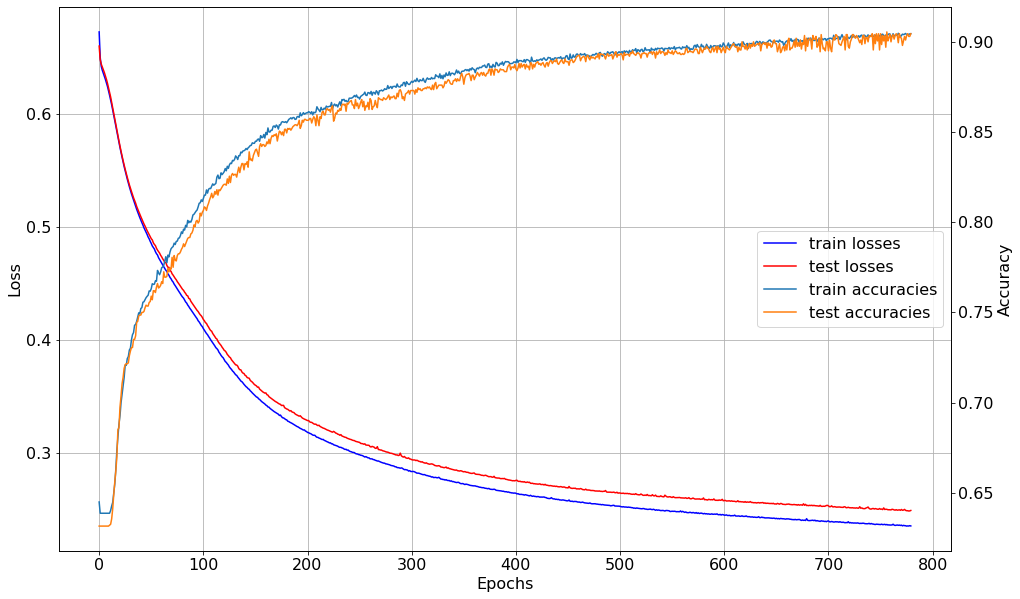

In [14]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ln1 = ax1.plot(train_losses, color='blue', label='train losses')
ln2 = ax1.plot(test_losses, color='red', label='test losses')

ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.grid()

ax2 = ax1.twinx()

ln3 = ax2.plot(train_accs, label='train accuracies')
ln4 = ax2.plot(test_accs, label='test accuracies')

ax2.set_ylabel('Accuracy')

lines = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='center right')

plt.show()

### Modified model

In [13]:
train_data = Data(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=200, shuffle=True)

test_data = Data(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True)

model = MLP().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
train_losses = []
train_accs = []
test_losses = []
test_accs = []
    
for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_loader, model, loss_fn)
    
    print(f'Accuracy: {(100 * test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Epoch 1
-------------------------------
Accuracy: 63.1%, Avg loss: 0.666698 

Epoch 2
-------------------------------
Accuracy: 63.1%, Avg loss: 0.652176 

Epoch 3
-------------------------------
Accuracy: 63.1%, Avg loss: 0.646388 

Epoch 4
-------------------------------
Accuracy: 63.1%, Avg loss: 0.643019 

Epoch 5
-------------------------------
Accuracy: 63.1%, Avg loss: 0.640536 

Epoch 6
-------------------------------
Accuracy: 63.1%, Avg loss: 0.638014 

Epoch 7
-------------------------------
Accuracy: 63.1%, Avg loss: 0.635316 

Epoch 8
-------------------------------
Accuracy: 63.1%, Avg loss: 0.632212 

Epoch 9
-------------------------------
Accuracy: 63.1%, Avg loss: 0.628808 

Epoch 10
-------------------------------
Accuracy: 63.1%, Avg loss: 0.624981 

Epoch 11
-------------------------------
Accuracy: 63.1%, Avg loss: 0.620767 

Epoch 12
-------------------------------
Accuracy: 63.2%, Avg loss: 0.616528 

Epoch 13
-------------------------------
Accuracy: 63.4%, Avg

Accuracy: 81.6%, Avg loss: 0.400191 

Epoch 108
-------------------------------
Accuracy: 81.2%, Avg loss: 0.399661 

Epoch 109
-------------------------------
Accuracy: 82.0%, Avg loss: 0.398053 

Epoch 110
-------------------------------
Accuracy: 81.5%, Avg loss: 0.396853 

Epoch 111
-------------------------------
Accuracy: 81.7%, Avg loss: 0.395824 

Epoch 112
-------------------------------
Accuracy: 81.4%, Avg loss: 0.394905 

Epoch 113
-------------------------------
Accuracy: 82.2%, Avg loss: 0.393431 

Epoch 114
-------------------------------
Accuracy: 82.0%, Avg loss: 0.392404 

Epoch 115
-------------------------------
Accuracy: 82.2%, Avg loss: 0.391247 

Epoch 116
-------------------------------
Accuracy: 82.2%, Avg loss: 0.390197 

Epoch 117
-------------------------------
Accuracy: 82.7%, Avg loss: 0.389120 

Epoch 118
-------------------------------
Accuracy: 82.5%, Avg loss: 0.387981 

Epoch 119
-------------------------------
Accuracy: 83.0%, Avg loss: 0.386874 

Ep

Accuracy: 86.5%, Avg loss: 0.319446 

Epoch 213
-------------------------------
Accuracy: 86.4%, Avg loss: 0.319565 

Epoch 214
-------------------------------
Accuracy: 86.5%, Avg loss: 0.318786 

Epoch 215
-------------------------------
Accuracy: 86.7%, Avg loss: 0.318016 

Epoch 216
-------------------------------
Accuracy: 87.0%, Avg loss: 0.317551 

Epoch 217
-------------------------------
Accuracy: 86.6%, Avg loss: 0.317260 

Epoch 218
-------------------------------
Accuracy: 86.7%, Avg loss: 0.316591 

Epoch 219
-------------------------------
Accuracy: 87.0%, Avg loss: 0.316168 

Epoch 220
-------------------------------
Accuracy: 86.8%, Avg loss: 0.315688 

Epoch 221
-------------------------------
Accuracy: 87.0%, Avg loss: 0.315392 

Epoch 222
-------------------------------
Accuracy: 87.2%, Avg loss: 0.315105 

Epoch 223
-------------------------------
Accuracy: 87.0%, Avg loss: 0.314975 

Epoch 224
-------------------------------
Accuracy: 87.0%, Avg loss: 0.314363 

Ep

Accuracy: 88.0%, Avg loss: 0.286164 

Epoch 318
-------------------------------
Accuracy: 88.2%, Avg loss: 0.285827 

Epoch 319
-------------------------------
Accuracy: 88.2%, Avg loss: 0.285715 

Epoch 320
-------------------------------
Accuracy: 87.8%, Avg loss: 0.286400 

Epoch 321
-------------------------------
Accuracy: 87.9%, Avg loss: 0.285664 

Epoch 322
-------------------------------
Accuracy: 88.2%, Avg loss: 0.285808 

Epoch 323
-------------------------------
Accuracy: 88.1%, Avg loss: 0.284732 

Epoch 324
-------------------------------
Accuracy: 88.3%, Avg loss: 0.284619 

Epoch 325
-------------------------------
Accuracy: 88.2%, Avg loss: 0.284433 

Epoch 326
-------------------------------
Accuracy: 87.9%, Avg loss: 0.284636 

Epoch 327
-------------------------------
Accuracy: 88.3%, Avg loss: 0.284005 

Epoch 328
-------------------------------
Accuracy: 88.1%, Avg loss: 0.283896 

Epoch 329
-------------------------------
Accuracy: 88.3%, Avg loss: 0.284236 

Ep

Accuracy: 89.0%, Avg loss: 0.269836 

Epoch 422
-------------------------------
Accuracy: 89.0%, Avg loss: 0.269547 

Epoch 423
-------------------------------
Accuracy: 88.6%, Avg loss: 0.269577 

Epoch 424
-------------------------------
Accuracy: 88.4%, Avg loss: 0.270404 

Epoch 425
-------------------------------
Accuracy: 88.8%, Avg loss: 0.268969 

Epoch 426
-------------------------------
Accuracy: 88.9%, Avg loss: 0.269014 

Epoch 427
-------------------------------
Accuracy: 88.6%, Avg loss: 0.269106 

Epoch 428
-------------------------------
Accuracy: 88.6%, Avg loss: 0.268695 

Epoch 429
-------------------------------
Accuracy: 88.9%, Avg loss: 0.268769 

Epoch 430
-------------------------------
Accuracy: 88.7%, Avg loss: 0.268431 

Epoch 431
-------------------------------
Accuracy: 88.8%, Avg loss: 0.268835 

Epoch 432
-------------------------------
Accuracy: 88.7%, Avg loss: 0.268250 

Epoch 433
-------------------------------
Accuracy: 88.8%, Avg loss: 0.268236 

Ep

Accuracy: 89.1%, Avg loss: 0.259810 

Epoch 525
-------------------------------
Accuracy: 89.3%, Avg loss: 0.260435 

Epoch 526
-------------------------------
Accuracy: 89.1%, Avg loss: 0.259704 

Epoch 527
-------------------------------
Accuracy: 89.3%, Avg loss: 0.259822 

Epoch 528
-------------------------------
Accuracy: 89.2%, Avg loss: 0.259461 

Epoch 529
-------------------------------
Accuracy: 89.1%, Avg loss: 0.259465 

Epoch 530
-------------------------------
Accuracy: 89.0%, Avg loss: 0.259481 

Epoch 531
-------------------------------
Accuracy: 89.1%, Avg loss: 0.259435 

Epoch 532
-------------------------------
Accuracy: 89.1%, Avg loss: 0.259356 

Epoch 533
-------------------------------
Accuracy: 89.3%, Avg loss: 0.259486 

Epoch 534
-------------------------------
Accuracy: 89.1%, Avg loss: 0.259285 

Epoch 535
-------------------------------
Accuracy: 89.2%, Avg loss: 0.259085 

Epoch 536
-------------------------------
Accuracy: 89.1%, Avg loss: 0.258974 

Ep

Accuracy: 89.5%, Avg loss: 0.253649 

Epoch 630
-------------------------------
Accuracy: 89.6%, Avg loss: 0.253297 

Epoch 631
-------------------------------
Accuracy: 89.6%, Avg loss: 0.253433 

Epoch 632
-------------------------------
Accuracy: 89.7%, Avg loss: 0.253430 

Epoch 633
-------------------------------
Accuracy: 89.2%, Avg loss: 0.255320 

Epoch 634
-------------------------------
Accuracy: 89.6%, Avg loss: 0.253391 

Epoch 635
-------------------------------
Accuracy: 89.8%, Avg loss: 0.253293 

Epoch 636
-------------------------------
Accuracy: 89.6%, Avg loss: 0.252973 

Epoch 637
-------------------------------
Accuracy: 89.8%, Avg loss: 0.253146 

Epoch 638
-------------------------------
Accuracy: 89.7%, Avg loss: 0.252929 

Epoch 639
-------------------------------
Accuracy: 89.6%, Avg loss: 0.253043 

Epoch 640
-------------------------------
Accuracy: 89.6%, Avg loss: 0.252923 

Epoch 641
-------------------------------
Accuracy: 89.6%, Avg loss: 0.253134 

Ep

Accuracy: 90.0%, Avg loss: 0.249329 

Epoch 733
-------------------------------
Accuracy: 89.8%, Avg loss: 0.249072 

Epoch 734
-------------------------------
Accuracy: 89.9%, Avg loss: 0.249029 

Epoch 735
-------------------------------
Accuracy: 89.8%, Avg loss: 0.249206 

Epoch 736
-------------------------------
Accuracy: 90.0%, Avg loss: 0.249190 

Epoch 737
-------------------------------
Accuracy: 89.8%, Avg loss: 0.248765 

Epoch 738
-------------------------------
Accuracy: 90.0%, Avg loss: 0.249047 

Epoch 739
-------------------------------
Accuracy: 89.9%, Avg loss: 0.248651 

Epoch 740
-------------------------------
Accuracy: 90.0%, Avg loss: 0.249167 

Epoch 741
-------------------------------
Accuracy: 89.8%, Avg loss: 0.248763 

Epoch 742
-------------------------------
Accuracy: 90.0%, Avg loss: 0.249226 

Epoch 743
-------------------------------
Accuracy: 90.0%, Avg loss: 0.248970 

Epoch 744
-------------------------------
Accuracy: 90.0%, Avg loss: 0.248826 

Ep

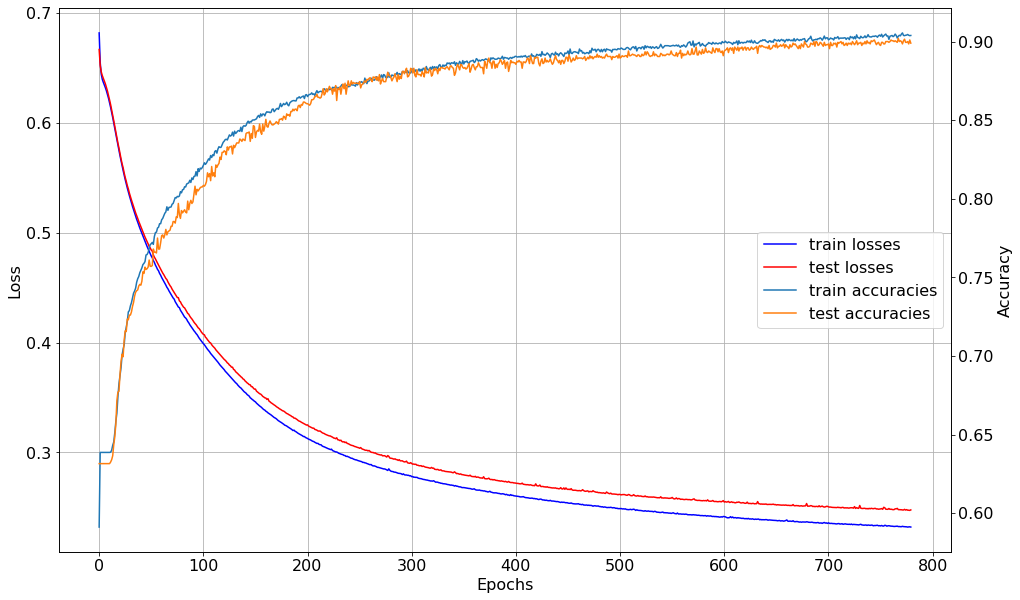

In [17]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ln1 = ax1.plot(train_losses, color='blue', label='train losses')
ln2 = ax1.plot(test_losses, color='red', label='test losses')

ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.grid()

ax2 = ax1.twinx()

ln3 = ax2.plot(train_accs, label='train accuracies')
ln4 = ax2.plot(test_accs, label='test accuracies')

ax2.set_ylabel('Accuracy')

lines = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='center right')

plt.savefig('output.jpg')
plt.show()

### Comparsion of different models

In [19]:
def fit_score(model, train_loader, test_loader, epochs):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()

    for epoch in range(epochs):        
        for X, y in train_loader:
            X, y = X.to(device).float(), y.to(device).float()

            pred = model(X).flatten()
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    model.eval()
    
    size = len(test_loader.dataset)
    correct = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device).float(), y.to(device).float()
            
            pred = model(X).flatten()            
            pred = (torch.sigmoid(pred) >= 0.5).float()
            
            correct += (pred == y).sum().item()
    return correct / size

In [20]:
scores = {
    'baseline_sklearn': [],
    'baseline_pytorch': [],
    'diff_activ': [],
    'diff_activ_bn': []
}

NUM_TRIALS = 20

for i in range(NUM_TRIALS):
    print(f'Trial {i + 1}\n-------------------------------')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    print('Training baseline_sklearn')    
    baseline_model = MLPClassifier((5,), 'logistic', max_iter=1000, random_state=0)
    baseline_model.fit(X_train, y_train)
    scores['baseline_sklearn'].append(baseline_model.score(X_test, y_test))
    
    epochs = baseline_model.n_iter_
    
    train_data = Data(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=200, shuffle=True,
                              worker_init_fn=seed_worker, generator=g)

    test_data = Data(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=200, shuffle=True,
                             worker_init_fn=seed_worker, generator=g)
    
    print('Training baseline_pytorch')    
    mlp = MLP().to(device)
    scores['baseline_pytorch'].append(fit_score(mlp, train_loader, test_loader, epochs))
    
    print('Training diff_activ')
    mlp_diff_activ = MLP_different().to(device)
    scores['diff_activ'].append(fit_score(mlp_diff_activ, train_loader, test_loader, epochs))
    
    print('Training diff_activ_bn\n')
    mlp_diff_activ_bn = MLP_different_bn().to(device)
    scores['diff_activ_bn'].append(fit_score(mlp_diff_activ_bn, train_loader, test_loader, epochs))

Trial 1
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 2
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 3
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 4
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 5
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 6
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 7
-------------------------------
Training baseline_sklearn
Training baseline_pytorch
Training diff_activ
Training diff_activ_bn

Trial 8
-------------------------------
Training

In [23]:
for i in scores.keys():
    mean = np.mean(scores[i])
    std = np.std(scores[i])
    scores[i].append(mean)
    scores[i].append(std)
    print(mean, std)

0.911475 0.005948686829881038
0.9177249999999999 0.015766638037324254
0.8771749999999999 0.019901805822588055
0.9123749999999999 0.018187822162095166


In [28]:
print(pd.DataFrame(scores).to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
{} &  baseline\_sklearn &  baseline\_pytorch &  diff\_activ &  diff\_activ\_bn \\
\midrule
0  &              0.91 &              0.91 &        0.86 &           0.91 \\
1  &              0.90 &              0.92 &        0.87 &           0.91 \\
2  &              0.90 &              0.93 &        0.92 &           0.91 \\
3  &              0.92 &              0.93 &        0.87 &           0.92 \\
4  &              0.92 &              0.93 &        0.86 &           0.94 \\
5  &              0.91 &              0.90 &        0.90 &           0.92 \\
6  &              0.92 &              0.91 &        0.88 &           0.91 \\
7  &              0.91 &              0.94 &        0.87 &           0.92 \\
8  &              0.91 &              0.94 &        0.90 &           0.92 \\
9  &              0.92 &              0.93 &        0.86 &           0.91 \\
10 &              0.91 &              0.91 &        0.90 &           0.91 \\
11 &              0.92 &      